# 개선된 U-Net 모델 만들기

## Step 1. KITTI 데이터셋 수집과 구축

In [1]:
import os
import math
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt
import skimage
from skimage.io import imread
from skimage.transform import resize
from glob import glob

from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

In [2]:
# 데이터셋 가져오기
!mkdir -p ~/aiffel/semantic_segmentation/data
!ln -s  ~/data/* ~/aiffel/semantic_segmentation/data/

ln: failed to create symbolic link '/aiffel/aiffel/semantic_segmentation/data/testing': File exists
ln: failed to create symbolic link '/aiffel/aiffel/semantic_segmentation/data/training': File exists


### 데이터 로더(data loader) 만들기

In [3]:
# Augmentation, Resize
from albumentations import  HorizontalFlip, RandomSizedCrop, Compose, OneOf, Resize

def build_augmentation(is_train=True):
  if is_train:    # 훈련용 데이터
    return Compose([
                    HorizontalFlip(p=0.5),    # 50%의 확률로 좌우대칭
                    RandomSizedCrop(         # 50%의 확률로 RandomSizedCrop
                        min_max_height=(300, 370),
                        w2h_ratio=370/1242,
                        height=224,
                        width=224,
                        p=0.5
                        ),
                    Resize(              # 입력이미지를 224X224로 resize
                        width=224,
                        height=224
                        )
                    ])
  return Compose([      # 테스트용 데이터
                Resize(                # 입력이미지를 224X224로 resize
                    width=224,
                    height=224
                    )
                ])

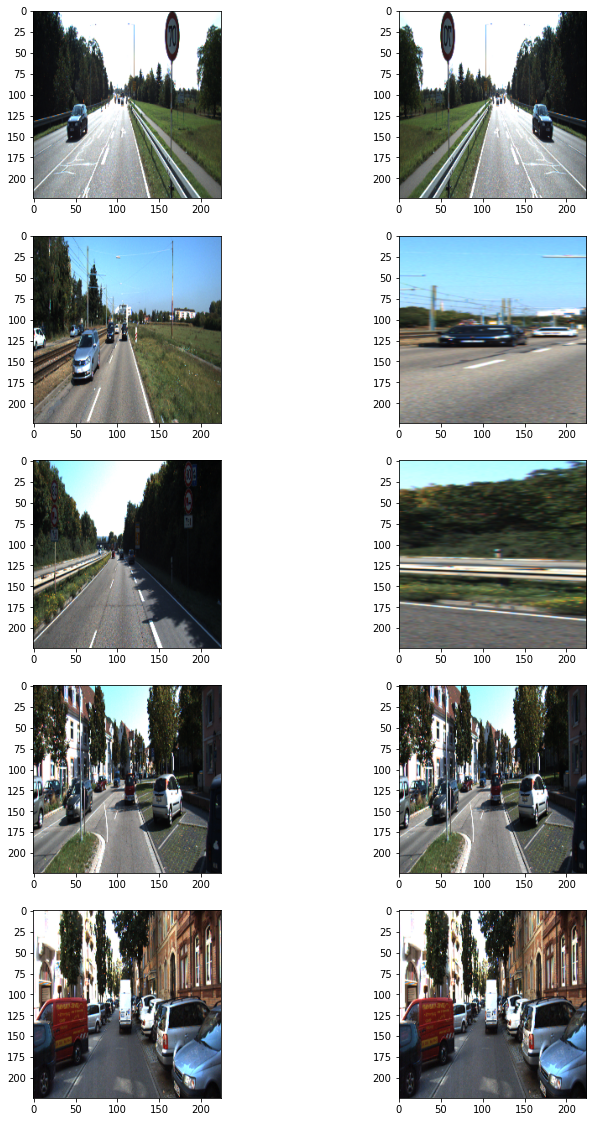

In [4]:
# 이미지 불러오기
dir_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/data/training'

augmentation_train = build_augmentation()
augmentation_test = build_augmentation(is_train=False)
input_images = glob(os.path.join(dir_path, "image_2", "*.png"))

# 훈련 데이터셋 5개에 augmentation 적용해보기
plt.figure(figsize=(12, 20))
for i in range(5):
    image = imread(input_images[i]) 
    image_data = {"image":image}
    resized = augmentation_test(**image_data)
    processed = augmentation_train(**image_data)
    plt.subplot(5, 2, 2*i+1)
    plt.imshow(resized["image"])  # 왼쪽이 원본이미지
    plt.subplot(5, 2, 2*i+2)
    plt.imshow(processed["image"])  # 오른쪽이 augment된 이미지
  
plt.show()

In [5]:
# 데이터셋 구성하기(tf.keras.utils.Sequence를 상속받은 generator 형태)
class KittiGenerator(tf.keras.utils.Sequence):
  '''
  KittiGenerator는 tf.keras.utils.Sequence를 상속받는다.
  KittiDataset을 원하는 방식으로 preprocess하기 위해 Sequnce를 커스텀해 사용한다.
  '''
  def __init__(self, 
               dir_path,
               batch_size=16,
               img_size=(224, 224, 3),
               output_size=(224, 224),
               is_train=True,
               augmentation=None):
    '''
    dir_path: dataset의 directory path
    batch_size: batch_size
    img_size: preprocess에 사용할 입력이미지의 크기
    output_size: ground_truth를 만들어주기 위한 크기
    is_train: Generator가 학습용인지 테스트용인지 구분
    augmentation: 적용하길 원하는 augmentation 함수를 인자로 받기
    '''
    self.dir_path = dir_path
    self.batch_size = batch_size
    self.is_train = is_train
    self.dir_path = dir_path
    self.augmentation = augmentation
    self.img_size = img_size
    self.output_size = output_size

    # load_dataset()을 통해서 kitti dataset의 directory path에서 라벨과 이미지 확인
    self.data = self.load_dataset()

  def load_dataset(self):
    # kitti dataset에서 필요한 정보(이미지 경로 및 라벨)를 directory에서 확인하고 로드하는 함수
    # is_train에 따라 test set을 분리해서 load 해야한다.
    input_images = glob(os.path.join(self.dir_path, "image_2", "*.png"))
    label_images = glob(os.path.join(self.dir_path, "semantic", "*.png"))
    input_images.sort()
    label_images.sort()
    assert len(input_images) == len(label_images)
    data = [ _ for _ in zip(input_images, label_images)]

    if self.is_train:
      return data[:-30]
    return data[-30:]
    
  def __len__(self):
    # Generator의 length로서 전체 dataset을 batch_size로 나누고 소숫점 첫째자리에서 올림한 값을 반환
    return math.ceil(len(self.data) / self.batch_size)

  def __getitem__(self, index):
    # 입력과 출력 만들기
    # 입력은 resize및 augmentation이 적용된 input image
    # 출력은 semantic label
    batch_data = self.data[
                           index*self.batch_size:
                           (index + 1)*self.batch_size
                           ]
    inputs = np.zeros([self.batch_size, *self.img_size])
    outputs = np.zeros([self.batch_size, *self.output_size])
        
    for i, data in enumerate(batch_data):
      input_img_path, output_path = data
      _input = imread(input_img_path)
      _output = imread(output_path)
      _output = (_output==7).astype(np.uint8)*1
      data = {
          "image": _input,
          "mask": _output,
          }
      augmented = self.augmentation(**data)
      inputs[i] = augmented["image"]/255
      outputs[i] = augmented["mask"]
      return inputs, outputs

  def on_epoch_end(self):
    # 한 epoch가 끝나면 실행되는 함수. 학습중인 경우에 순서를 random shuffle하도록 적용.
    self.indexes = np.arange(len(self.data))
    if self.is_train == True :
      np.random.shuffle(self.indexes)
      return self.indexes

In [6]:
# 위의 함수들 적용하기
augmentation = build_augmentation()
test_preproc = build_augmentation(is_train=False)
        
train_generator = KittiGenerator(
    dir_path, 
    augmentation=augmentation,
)

test_generator = KittiGenerator(
    dir_path, 
    augmentation=test_preproc,
    is_train=False
)

## Step 2. U-Net 모델의 구현
### 모델 구조 만들기

![unet](https://user-images.githubusercontent.com/116326867/215251103-6e0f473c-68ba-455e-bea3-fa91a16ece4a.png)

In [7]:
def unet_model(input_shape=(224, 224, 3)):
  inputs = Input(input_shape)

  #Contracting Path
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
  conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
  pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
  conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
  pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
  conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
  pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
  conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
  drop4 = Dropout(0.5)(conv4)
  pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
  conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
  
  #Expanding Path
  drop5 = Dropout(0.5)(conv5)
  up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
  merge6 = concatenate([drop4,up6], axis = 3)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
  conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
  up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
  merge7 = concatenate([conv3,up7], axis = 3)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
  conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
  up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
  merge8 = concatenate([conv2,up8], axis = 3)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
  conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
  up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
  merge9 = concatenate([conv1,up9], axis = 3)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
  conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
  conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)     
  conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

  model = Model(inputs = inputs, outputs = conv10)
  return model

### 모델 학습하기

In [9]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

unet_model = unet_model()
unet_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history_unet = unet_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_model.save(model_path)  #학습한 모델 저장하기

Epoch 1/100
11/11 [==============================] - 8s 622ms/step - loss: 0.6817 - val_loss: 0.6605
Epoch 2/100
11/11 [==============================] - 6s 588ms/step - loss: 0.3859 - val_loss: 0.2820
Epoch 3/100
11/11 [==============================] - 6s 572ms/step - loss: 0.2364 - val_loss: 0.2819
Epoch 4/100
11/11 [==============================] - 6s 568ms/step - loss: 0.2022 - val_loss: 0.2819
Epoch 5/100
11/11 [==============================] - 6s 568ms/step - loss: 0.2107 - val_loss: 0.2819
Epoch 6/100
11/11 [==============================] - 6s 567ms/step - loss: 0.2677 - val_loss: 0.2819
Epoch 7/100
11/11 [==============================] - 6s 564ms/step - loss: 0.2311 - val_loss: 0.2819
Epoch 8/100
11/11 [==============================] - 6s 564ms/step - loss: 0.2378 - val_loss: 0.2819
Epoch 9/100
11/11 [==============================] - 6s 563ms/step - loss: 0.2189 - val_loss: 0.2819
Epoch 10/100
11/11 [==============================] - 6s 561ms/step - loss: 0.2113 - val_lo

11/11 [==============================] - 6s 562ms/step - loss: 0.2298 - val_loss: 0.2819
Epoch 82/100
11/11 [==============================] - 6s 562ms/step - loss: 0.1976 - val_loss: 0.2819
Epoch 83/100
11/11 [==============================] - 6s 562ms/step - loss: 0.2025 - val_loss: 0.2819
Epoch 84/100
11/11 [==============================] - 6s 563ms/step - loss: 0.2213 - val_loss: 0.2819
Epoch 85/100
11/11 [==============================] - 6s 562ms/step - loss: 0.1827 - val_loss: 0.2819
Epoch 86/100
11/11 [==============================] - 6s 562ms/step - loss: 0.2105 - val_loss: 0.2819
Epoch 87/100
11/11 [==============================] - 6s 562ms/step - loss: 0.2104 - val_loss: 0.2819
Epoch 88/100
11/11 [==============================] - 6s 563ms/step - loss: 0.2646 - val_loss: 0.2819
Epoch 89/100
11/11 [==============================] - 6s 563ms/step - loss: 0.2924 - val_loss: 0.2819
Epoch 90/100
11/11 [==============================] - 6s 563ms/step - loss: 0.2098 - val_loss: 

## Step 3. U-Net++ 모델의 구현
### 모델 구조 만들기
![unetplusplus](https://user-images.githubusercontent.com/116326867/215288065-b6f5722a-bbee-4c06-b6dd-10a032f9c1e0.png)

In [ ]:
def unet_plus_model(input_shape=(224, 224, 3), deep_supervision=True, batch_size=4):
    
    inputs = Input(input_shape)
    
    # Backbone
    # Convolution Node X(0,0) : Down-sampling
    conv0_0 = Conv2D(64, 3, padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    pool0_0 = MaxPooling2D(pool_size=(2, 2))(conv0_0)
    
    # Convolution Node X(1,0) : Down-sampling
    conv1_0 = Conv2D(128, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool0_0)
    pool1_0 = MaxPooling2D(pool_size=(2, 2))(conv1_0)
    
    # Convolution Node X(2,0) : Down-sampling
    conv2_0 = Conv2D(256, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool1_0)
    pool2_0 = MaxPooling2D(pool_size=(2, 2))(conv2_0)
    
    # Convolution Node X(3,0) : Down-sampling
    conv3_0 = Conv2D(512, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool2_0)
    pool3_0 = MaxPooling2D(pool_size=(2, 2))(conv3_0)
    
    # Convolution Node X(4,0) : Down-sampling
    conv4_0 = Conv2D(1024, 3, padding='same', activation='relu', kernel_initializer='he_normal')(pool3_0)
    pool4_0 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    


    # 첫번째 대각선
    # Node (x, y=1)
    # Convolution Node X(0,1) : Up-sampling and Skip Connection
    # Up-sampling : Node X(1,0)
    # Skip Connection : Node X(0,0)
    conv_up1_0 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv1_0)
    merge0_1 = concatenate([conv_up1_0, conv0_0], axis=3)
    conv0_1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_1)
    
    # Convolution Node X(1,1) : Up-sampling and Skip Connection
    # Up-sampling : Node X(2,0)
    # Skip Connection : Node X(1,0)
    conv_up2_0 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv2_0)
    merge1_1 = concatenate([conv_up2_0, conv1_0], axis=3)
    conv1_1 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_1)
    
    # Convolution Node X(2,1) : Up-sampling and Skip Connection
    # Up-sampling : Node X(3,0)
    # Skip Connection : Node X(2,0)
    conv_up3_0 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv3_0)
    merge2_1 = concatenate([conv_up3_0, conv2_0], axis=3)
    conv2_1 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_1)
    
    # Convolution Node X(3,1) : Up-sampling and Skip Connection
    # Up-sampling : Node X(4,0)
    # Skip Connection : Node X(3,0)
    conv_up4_0 = Conv2DTranspose(512, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv4_0)
    merge3_1 = concatenate([conv_up4_0, conv3_0], axis=3)
    conv3_1 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge3_1)
    


    # 두번째 대각선
    # Node (x, y=2)
    # Convolution Node X(0,2) : Up-sampling and Skip Connection x2
    # Up-sampling : Node X(1,1)
    # Skip Connection : Node X(0,0), Node X(0,1)
    conv_up1_1 = Conv2DTranspose(64, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv1_1)
    merge0_2 = concatenate([conv_up1_1, conv0_0, conv0_1], axis=3)
    conv0_2 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_2)
    
    # Convolution Node X(1,2) : Up-sampling and Skip Connection x2
    # Up-sampling : Node X(2,1)
    # Skip Connection : Node X(1,0), Node X(1,1)
    conv_up2_1 = Conv2DTranspose(128, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv2_1)
    merge1_2 = concatenate([conv_up2_1, conv1_0, conv1_1], axis=3)
    conv1_2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_2)
    
    # Convolution Node X(2,2) : Up-sampling and Skip Connection x2
    # Up-sampling : Node X(3,1)
    # Skip Connection : Node X(2,0), Node X(2,1)
    conv_up3_1 = Conv2DTranspose(256, 2, strides=(2, 2), activation='relu', kernel_initializer='he_normal')(conv3_1)
    merge2_2 = concatenate([conv_up3_1, conv2_0, conv2_1], axis=3)
    conv2_2 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge2_2)
    


    # 세번째 대각선
    # Node (x, y=3)
    # Convolution Node X(0,3) : Up-sampling and Skip Connection x3
    # Up-sampling : Node X(1,2)
    # Skip Connection : Node X(0,0), Node X(0,1), Node X(0,2)
    conv_up1_2 = Conv2DTranspose(64, 2, strides = (2, 2), activation = 'relu', kernel_initializer='he_normal')(conv1_2)
    merge0_3 = concatenate([conv_up1_2, conv0_0, conv0_1, conv0_2], axis = 3)
    conv0_3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_3)
    
    # Convolution Node X(0,3) : Up-sampling and Skip Connection x3
    # Up-sampling : Node X(2,2)
    # Skip Connection : Node X(1,0), Node X(1,1), Node X(1,2)
    conv_up2_2 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv2_2))
    # conv_up2_2 = Conv2DTranspose(128, 2, strides = (2, 2), activation = 'relu', kernel_initializer='he_normal')(conv2_2)
    merge1_3 = concatenate([conv_up2_2, conv1_0, conv1_1, conv1_2], axis = 3)
    conv1_3 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge1_3)
    


    # 네번째 대각선
    # Node (x, y=4)
    # Convolution Node X(0,4) : Up-sampling and Skip Connection x4
    # Up-sampling : Node X(1,3)
    # Skip Connection : Node X(0,0), Node X(0,1), Node X(0,2), Node X(0,3)
    conv_up1_3 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2, 2))(conv1_3))
    # conv_up1_3 = Conv2DTranspose(64, 2, strides = (2, 2), activation = 'relu', kernel_initializer='he_normal')(conv1_3)
    merge0_4 = concatenate([conv_up1_3, conv0_0, conv0_1, conv0_2, conv0_3], axis=3)
    conv0_4 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge0_4)



    # deep_supervision
    output1 = Conv2D(1, 1, activation='sigmoid', name = 'output1')(conv0_1)
    output2 = Conv2D(1, 1, activation='sigmoid', name = 'output2')(conv0_2)
    output3 = Conv2D(1, 1, activation='sigmoid', name = 'output3')(conv0_3)
    output4 = Conv2D(1, 1, activation='sigmoid', name = 'output4')(conv0_4)
    
    if deep_supervision:
        model = Model(inputs=inputs, outputs=[output1, output2, output3, output4])
    else:
        model = Model(inputs=inputs, outputs=output4)

    return model

In [ ]:
model_path = os.getenv('HOME')+'/aiffel/semantic_segmentation/seg_model_unet.h5'

unet_plus_model = unet_plus_model()
unet_plus_model.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
history_unet_plus = unet_plus_model.fit(
     train_generator,
     validation_data=test_generator,
     steps_per_epoch=len(train_generator),
     epochs=100,
 )

unet_plus_model.save(model_path)  #학습한 모델 저장하기

## Step 4. U-Net 과 U-Net++ 모델이 수행한 세그멘테이션 결과 분석

### 시각화 비교 - U-Net

In [ ]:
# u_net 학습한 모델 불러오기
unet_model = tf.keras.models.load_model(model_path)

In [ ]:
# image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 이를 output_path에 저장하는 함수
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
    
# 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
# IoU 계산
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

# get_output 확장
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _
    
# 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
output, prediction, target = get_output(
     unet_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### 시각화 비교 - U-Net++

In [ ]:
# u_net++ 학습한 모델 불러오기
unet_plus_model = tf.keras.models.load_model(model_path)

In [ ]:
# image_path로 입력된 이미지를 입력받아 preprocess를 해서 model로 infernece한 결과를 시각화하고 이를 output_path에 저장하는 함수
def get_output(model, preproc, image_path, output_path):
     origin_img = imread(image_path)
     data = {"image":origin_img}
     processed = preproc(**data)
     output = model(np.expand_dims(processed["image"]/255,axis=0))
     output = (output[0].numpy()>0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
     output = Image.fromarray(output)
     background = Image.fromarray(origin_img).convert('RGBA')
     output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
     output = Image.blend(background, output, alpha=0.5)
     output.show()
     return output
    
# 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
get_output(
     unet_plus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png'
 )

In [ ]:
# IoU 계산
def calculate_iou_score(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = float(np.sum(intersection)) / float(np.sum(union))
    print('IoU : %f' % iou_score )
    return iou_score

# get_output 확장
def get_output(model, preproc, image_path, output_path, label_path):
    origin_img = imread(image_path)
    data = {"image":origin_img}
    processed = preproc(**data)
    output = model(np.expand_dims(processed["image"]/255,axis=0))
    output = (output[0].numpy()>=0.5).astype(np.uint8).squeeze(-1)*255  #0.5라는 threshold를 변경하면 도로인식 결과범위가 달라진다.
    prediction = output/255   # 도로로 판단한 영역
    
    output = Image.fromarray(output)
    background = Image.fromarray(origin_img).convert('RGBA')
    output = output.resize((origin_img.shape[1], origin_img.shape[0])).convert('RGBA')
    output = Image.blend(background, output, alpha=0.5)
    output.show()   # 도로로 판단한 영역을 시각화
     
    if label_path:   
        label_img = imread(label_path)
        label_data = {"image":label_img}
        label_processed = preproc(**label_data)
        label_processed = label_processed["image"]
        target = (label_processed == 7).astype(np.uint8)*1   # 라벨에서 도로로 기재된 영역

        return output, prediction, target
    else:
        return output, prediction, _
    
# 시각화
i = 1    # i값을 바꾸면 테스트용 파일이 달라진다. 
output, prediction, target = get_output(
     unet_plus_model, 
     test_preproc,
     image_path=dir_path + f'/image_2/00{str(i).zfill(4)}_10.png',
     output_path=dir_path + f'./result_{str(i).zfill(3)}.png',
     label_path=dir_path + f'/semantic/00{str(i).zfill(4)}_10.png'
 )

calculate_iou_score(target, prediction)

### IoU 비교

------

## 회고

## Reference